In [1]:
import torch
import sys
import os
import json
import time
import numpy as np
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.losses import SingleVisLoss, UmapLoss, ReconstructionLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
import singleVis.config as config
from singleVis.eval.evaluator import Evaluator
from singleVis.spatial_edge_constructor import kcSpatialEdgeConstructor
from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.trajectory import draw_trajectory, draw_two_trajectories

In [2]:
dataset = "symmetric"
DATASET = "cifar10"
CONTENT_PATH ="/home/xianglin/projects/DVI_data/noisy/{}/cifar10/".format(dataset)
DATASET = "cifar10_n"

In [2]:
DATASET = "cifar10"
CONTENT_PATH ="/home/xianglin/projects/DVI_data/resnet18_cifar10"
DATASET = "cifar10_full"

In [3]:
LEN = config.dataset_config[DATASET]["TRAINING_LEN"]
LAMBDA = config.dataset_config[DATASET]["LAMBDA"]
L_BOUND = config.dataset_config[DATASET]["L_BOUND"]
MAX_HAUSDORFF = config.dataset_config[DATASET]["MAX_HAUSDORFF"]
ALPHA = config.dataset_config[DATASET]["ALPHA"]
BETA = config.dataset_config[DATASET]["BETA"]
INIT_NUM = config.dataset_config[DATASET]["INIT_NUM"]
EPOCH_START = config.dataset_config[DATASET]["EPOCH_START"]
EPOCH_END = config.dataset_config[DATASET]["EPOCH_END"]
EPOCH_PERIOD = config.dataset_config[DATASET]["EPOCH_PERIOD"]
HIDDEN_LAYER = config.dataset_config[DATASET]["HIDDEN_LAYER"]

# define hyperparameters
DEVICE = torch.device("cuda:{:d}".format(0) if torch.cuda.is_available() else "cpu")
S_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["S_N_EPOCHS"]
B_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["B_N_EPOCHS"]
T_N_EPOCHS = config.dataset_config[DATASET]["training_config"]["T_N_EPOCHS"]
N_NEIGHBORS = config.dataset_config[DATASET]["training_config"]["N_NEIGHBORS"]
PATIENT = config.dataset_config[DATASET]["training_config"]["PATIENT"]
MAX_EPOCH = config.dataset_config[DATASET]["training_config"]["MAX_EPOCH"]

content_path = CONTENT_PATH
sys.path.append(content_path)

from Model.model import *
net = resnet18()
classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [4]:
data_provider = NormalDataProvider(content_path, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, verbose=1)
model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=HIDDEN_LAYER)
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
criterion = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA)
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
edge_loader = None
trainer = SingleVisTrainer(model, criterion, optimizer, lr_scheduler,edge_loader=edge_loader, DEVICE=DEVICE)
trainer.model.to(DEVICE)
trainer.model.eval()

Finish initialization...


SingleVisualizationModel(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=256, out_features=256, 

In [5]:
samples = np.zeros((161, 50000, 512))
for i in range(0, 161, 1):
    samples[i] = data_provider.train_representation(i+40)

In [6]:
import json
path = "/home/xianglin/projects/DVI_data/noisy/{}/cifar10/clean_label.json".format(dataset)
with open(path, "r") as f:
    clean_label = json.load(f)
path = "/home/xianglin/projects/DVI_data/noisy/{}/cifar10/noisy_label.json".format(dataset)
with open(path, "r") as f:
    noisy_label = json.load(f)

In [7]:
import numpy as np
# noisy_ones = np.array(clean_label) != np.array(noisy_label)
train_labels = data_provider.train_labels(40)

In [7]:
embeddings_2d = np.zeros((50000, 161, 2))
for i in range(50000):
    embedding_2d = trainer.model.encoder(torch.from_numpy(samples[:,i,:]).to(device=DEVICE, dtype=torch.float)).cpu().detach().numpy()
    embeddings_2d[i] = embedding_2d

In [9]:
directions = np.zeros((50000, 160,2))
for i in range(50000):
    directions[i] = embeddings_2d[i,1:,:]-embeddings_2d[i, :-1,:]

In [20]:
# cls = np.argwhere(train_labels==9).squeeze()
cls = np.argwhere(np.array(noisy_label)==9).squeeze()

In [21]:
np.sum(np.array(clean_label)[cls]==9), len(cls)-np.sum(np.array(clean_label)[cls]==9)

(4015, 961)

In [22]:
import umap.umap_ as umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(directions[cls].reshape(len(cls), -1))
# embedding = reducer.fit_transform(directions.reshape(50000, -1))
embedding.shape

(4976, 2)

Text(0.5, 1.0, 'UMAP projection')

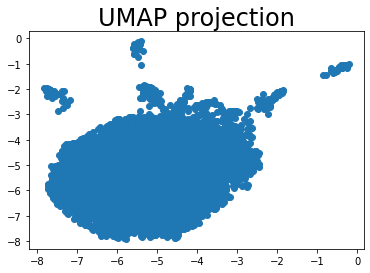

In [23]:
import matplotlib.pyplot as plt
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],)
plt.title('UMAP projection', fontsize=24)

In [25]:
np.sum(embedding[:,1]>-3)

513